In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../../module/')

import keras2
from keras2.models import Model
from keras2.layers import concatenate, Dense, Input, Flatten
from keras2.optimizers import Adam
from util import moving_average, dlqr, discretized_system, lqr
import gym2
from rl2.agents import selfDDPGAgent, selfDDPGAgent2
from rl2.memory import SequentialMemory

Using TensorFlow backend.
Using TensorFlow backend.


In [2]:
# GymのPendulum環境を作成
env = gym2.make("Pendulum-v2")

# 取りうる”打ち手”のアクション数と値の定義
nb_actios = 2
ACT_ID_TO_VALUE = {0: [-1], 1: [+1]}

In [3]:
def critic_net(a_shape , s_shape):
    action_input = Input(a_shape)
    observation_input = Input(shape=(1,)+s_shape)
    flattened_observation = Flatten()(observation_input)
    x = concatenate([action_input, flattened_observation])
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(1, activation="linear")(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    return (critic, action_input)

def branch_actor(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input) # 実質的なinput layer
    
    x1 = Dense(8, activation="relu")(x)
    x1 = Dense(8, activation="relu")(x1)
    x1 = Dense(1, activation="multiple_tanh")(x1) # action signal
    
    x2 = Dense(8, activation="relu")(x)
    x2 = Dense(8, activation="relu")(x2)
    x2 = Dense(1, activation="tau_output")(x2) # tau
    
    output = concatenate([x1, x2])
    actor = Model(inputs=action_input, outputs=output)
    return actor

# どうやって学習率を変える？

def agent2(a_shape, s_shape):
    actor = branch_actor(a_shape, s_shape)
    critic,  critic_action_input = critic_net(a_shape, s_shape)
    memory = SequentialMemory(limit = 50000, window_length = 1)
    agent = selfDDPGAgent2(
        a_shape[0],
        actor,
        critic,
        critic_action_input,
        memory,
        original_noise=True,
        clip_com = 0.01,
        batch_size = 128,
    )
    return agent

In [7]:
#safe learning   
l = 5.
step = 200000  # num of interval
episode_step = step
a = agent2((2,), (2,))
a.compile(Adam(lr=0.001, clipnorm=1.), metrics=["mae"], action_lr=0.001, tau_lr=0.0001)
a.actor.load_weights('./saved_agent/self_trigger_split_01.h5')
# a.load_weights('../learned_models_vol2/0.5standup-agent.h5')
# a.load_weights('../../learned_models_stab/lqr_optimal_agent.h5')
out = a.fit(env, l=l, nb_steps=step, visualize=0, verbose=1, nb_max_episode_steps=episode_step)

Training for 200000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 90s 9ms/step - reward: 0.1831
769 episodes - episode_reward: 2.334 [-22.124, 46.949] - loss: 0.047 - mean_absolute_error: 0.148 - mean_q: 1.210

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 95s 10ms/step - reward: 0.2553
97 episodes - episode_reward: 26.564 [-14.426, 48.858] - loss: 0.147 - mean_absolute_error: 0.179 - mean_q: 5.871

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 100s 10ms/step - reward: -0.1037
193 episodes - episode_reward: -5.267 [-27.133, 30.578] - loss: 1.352 - mean_absolute_error: 0.344 - mean_q: 12.154

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 105s 10ms/step - reward: -0.2037
100 episodes - episode_reward: -20.266 [-33.574, 0.540] - loss: 5.972 - mean_absolute_error: 0.685 - mean_q: 22.328

Interval 5 (40000 steps performed)
10000/10000 [=======

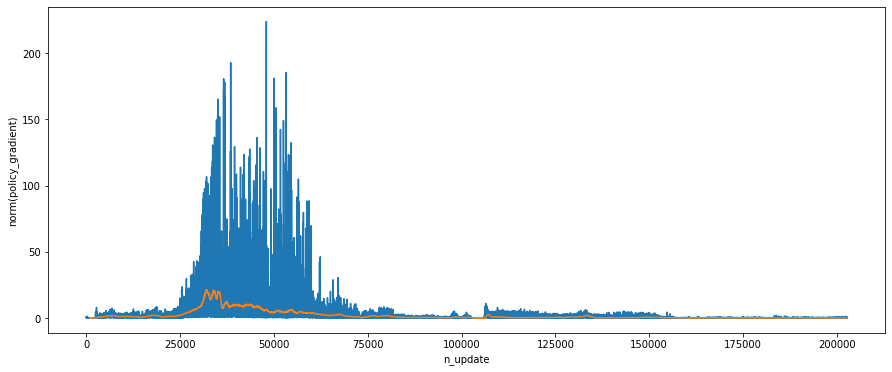

In [8]:
# gradient changing log
grads = np.array(a.gradient_log)
ma = moving_average(grads, 1000)
plt.figure(figsize=(15,6))
plt.plot(range(grads.shape[0]),grads)
plt.plot(range(1000,grads.shape[0]), ma)
plt.ylabel('norm(policy_gradient)')
plt.xlabel('n_update')
plt.show()

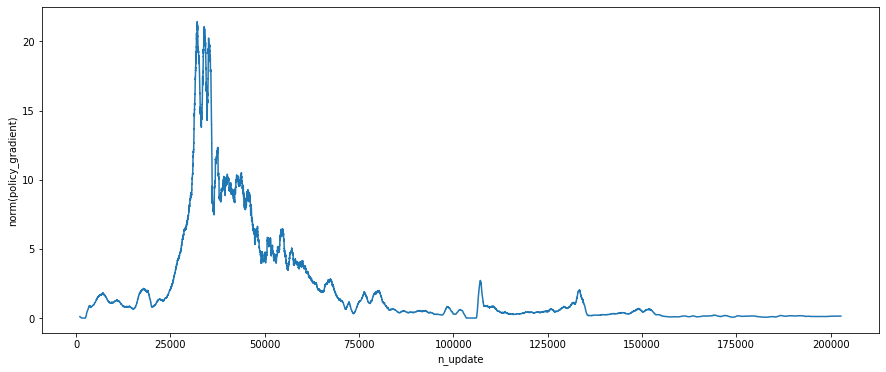

In [10]:
plt.figure(figsize=(15,6))
plt.plot(range(1000,grads.shape[0]), ma)
plt.ylabel('norm(policy_gradient)')
plt.xlabel('n_update')
plt.show()

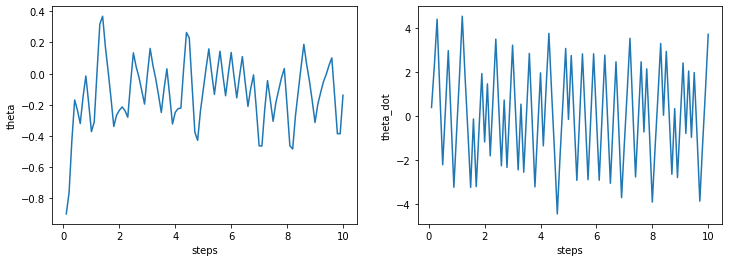

In [15]:
%matplotlib inline
def rad_clip(th):
    r = abs(th)
    while r > np.pi:
        r -= 2 * np.pi
    th = np.sign(th) * r
    return th

l = 5.
a.original_noise = False
env.reset()
env.set_state(np.array([-0.9, 0.4]))
states = []
time_limit = 10
time_log = []
taus = []
acc_time = 0
episode_reward = 0
while True:
    reward = 0
    x = env.state
    states.append([rad_clip(x[0]), x[1]])
    a_agent, tau = a.forward(x)
    taus.append(tau)
    acc_time += tau
    time_log.append(acc_time)
    action_repetition = int(np.ceil(200 * tau))  # minimum natural number which makes `dt` smaller than 0.005
    dt = tau / action_repetition
    # print(tau, dt, action_repetition)
    for p in range(action_repetition):
        _,_,r,_ = env.step(np.array([a_agent]), dt, tau)
        reward += r
    reward *= dt
    reward += - 0.01 * a_agent**2 + l * tau
    episode_reward += reward
    if acc_time > time_limit:
        break
states = np.array(states)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.xlabel('steps')
plt.ylabel('theta')
plt.plot(time_log, states[:,0])
plt.subplot(1,2,2)
plt.xlabel('steps')
plt.ylabel('theta_dot')
plt.plot(time_log, states[:,1])
plt.show()

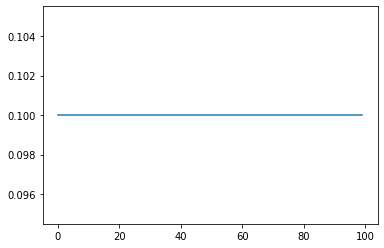

In [16]:
plt.plot(taus)

In [1]:
states = []
taus = []
high = np.array([np.pi, 8])
for _ in range(500):
    x = np.random.uniform(low=-high, high=high)
    states.append(x)
    action = a.forward(x)
    taus.append(action[1])
states = np.array(states)

NameError: name 'np' is not defined

In [ ]:
%matplotlib notebook

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
ax.set_xlabel('theta')
ax.set_ylabel('theta_dot')
ax.set_zlabel('tau')
ax.set_zlim3d(0.001,0.1)

ax.scatter3D(states[:,0], states[:,1], taus, marker='.', alpha=0.4)

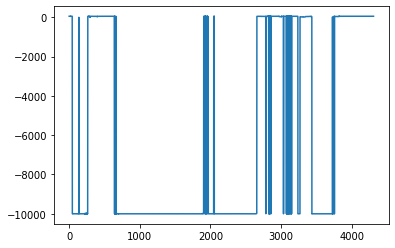

In [28]:
plt.plot(out.history['episode_reward'])

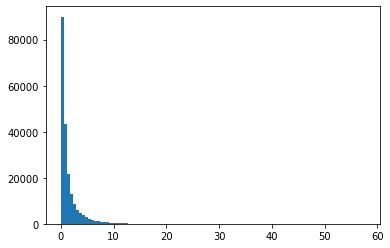

In [31]:
plt.hist(grads, bins=100)
plt.show()

In [37]:
mem = a.memory.sample(50000)
states = []
actions = []
for m in mem:
    states.append(m.state0[0])
    actions.append(m.action)
states = np.array(states)
actions = np.array(actions)

In [8]:
a.combined_inputs

[<tf.Tensor 'model_1/concatenate_1/concat:0' shape=(?, 2) dtype=float32>,
 <tf.Tensor 'input_3:0' shape=(?, 1, 2) dtype=float32>]